In [12]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from interpolation import interpolation
from scipy.spatial import ConvexHull, convex_hull_plot_2d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Notebook Summary:

**Problem** We currently use a block centroid to proxy a block (average at the record level). As a result, a centroid of a block will be closer to the side with more dwellings or dwellings with more people living in. 
**Goal:** Which proxy for block center is the most appropriate\
**In this notebook:** Compare three approaches to compute a center of a block
1. Center of mass (centroid): average of x and y co-ordinates of all records in a block
2. Hull centroid: average of x and y co-ordinates of records that create a block hull
3. Hull center: the middle points between the max and the min of each of the x and y co-ordinates

The analysis on centroid is also applicable to the other two alternatives. See `Block Centroids and What They Represent, 1850.ipynb` for more detailed inspection.

**note**: decision has not been made.

#### Get Data

In [14]:
#Change these values to rerun the notebook
filled_1850 = pd.read_csv("../../data/dwelling_filled_sum_1850_mn_v01.csv")
cd_1850 = pd.read_csv("../../data/cd_1850_XYupdate.csv") #For calculating centroids
filled_1850.rename(columns = {"CENSUS_WARD_NUM":"Ward_Num", "CENSUS_SERIALP":"CENSUS_SERIALB", "BLOCK_NUM":"block_num", "CENSUS_REEL_HOUSEHOLD":"CENSUS_REEL", "CENSUS_SEX":"CENSUS_SEXB", "CENSUS_PAGENO_HOUSEHOLD":"CENSUS_PAGENUM", "CENSUS_RACE":"CENSUS_RACEB", "CD_X":"cd_X", "CD_Y":"cd_Y"}, inplace = True)
ward_col = "Ward_Num"
dwelling_col = "dwelling_id"
dwelling_col_num = "CENSUS_DWELLING_NUM"
block_col = "block_num"
x_col = "cd_X"
y_col = "cd_Y"
pagenum = "CENSUS_PAGENNO"

In [15]:
dwellings_1850 = filled_1850.groupby([ward_col, dwelling_col], as_index = False).first()

In [53]:
def centroid_vis(ward, block, block_centroids, names, cd):
    for bc, nm in zip(block_centroids, names):
        plt.scatter(bc[ward][block][0],bc[ward][block][1], label = nm, s = 10)
#     plt.scatter(centroid_2[ward][block][0],centroid_2[ward][block][1], label = "centroid_hull", s = 10)
#     plt.scatter(centroid_3[ward][block][0],centroid_3[ward][block][1], label = "center", s = 10)
    df = cd[(cd["Ward_Num"] == ward) & (cd["block_num"] == block)]
    plt.scatter(df.cd_X, df.cd_Y, label = "block", alpha = 0.5, s = 5)
    plt.legend()
    plt.title("Centroid and known dwellings Ward "+str(ward)+ " Block "+ str(block)+", 1850")
    plt.tight_layout()
    epsilon = 0.0005
    plt.xlim(min(df.cd_X) - epsilon, max(df.cd_X) + epsilon)
    plt.ylim(min(df.cd_Y) - epsilon, max(df.cd_Y) + epsilon)
    plt.show()
    print("Total known dwellings in block:", len(df))
    
def get_hull_centroid(x_list, y_list):
    points = np.array([[x, y] for x, y in zip(x_list, y_list)])
    if len(points) < 3:
        return np.mean(points, axis=0)
    hull = ConvexHull(points)
    centriod = np.mean(hull.points[hull.vertices], axis=0)
    return (centriod[0],centriod[1])

def get_center(x_list, y_list):
    if len(x_list) < 2:
#         print((x_list.values[0], y_list.values[0]))
        return (x_list.values[0], y_list.values[0])
    return ((max(x_list) + min(x_list))/2, (max(y_list) + min(y_list))/2)

In [65]:
block_centroids = {ward:{block:interpolation.make_centroid(df_block[x_col], df_block[y_col]) for block, df_block in df.drop_duplicates([block_col, x_col, y_col]).groupby(block_col)} for ward,df in cd_1850.groupby(ward_col)}
hull_centroids = {ward:{block:get_hull_centroid(df_block[x_col], df_block[y_col]) for block, df_block in df.drop_duplicates([block_col, x_col, y_col]).groupby(block_col)} for ward,df in cd_1850.groupby(ward_col)}
hull_center = {ward:{block:get_center(df_block[x_col], df_block[y_col]) for block, df_block in df.drop_duplicates([block_col, x_col, y_col]).groupby(block_col)} for ward,df in cd_1850.groupby(ward_col)}

center_list = [block_centroids, hull_centroids, hull_center]
name_list = ['Block Centroid', 'Hull Centroid', 'Hull Center']

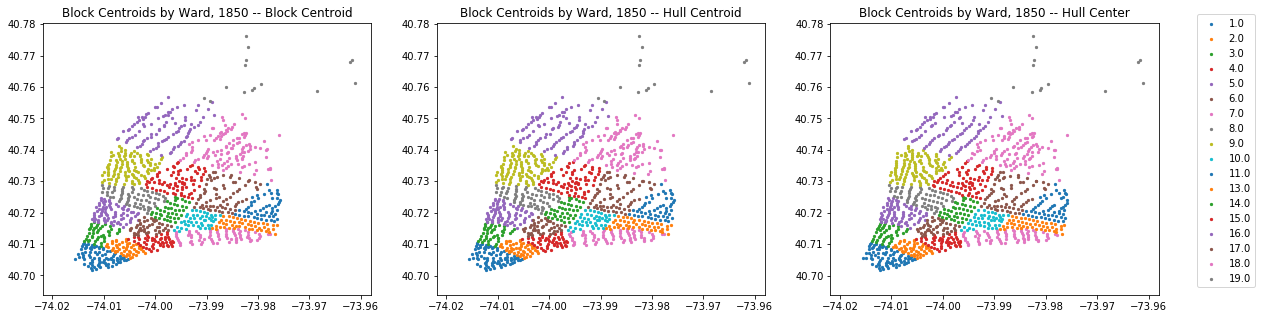

In [66]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))

for ax, cntr, nm in zip(axes, center_list, name_list):
    for key in cntr.keys():
        ax.scatter([value[0] for value in cntr[key].values()], [value[1] for value in cntr[key].values()], label = key, s = 5)
    
#     ax.tight_layout()
    ax.set_title("Block Centroids by Ward, 1850 -- "+ nm)
#     plt.show()
ax.legend(bbox_to_anchor=(1.1, 1.05))

Three approaches do not noticeably differ in the big picture

## Where they are on the map

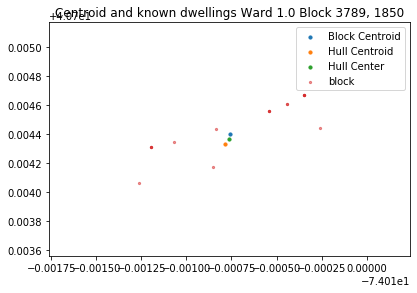

Total known dwellings in block: 17


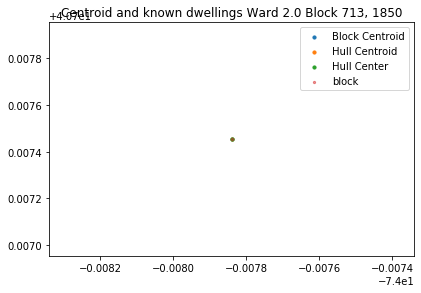

Total known dwellings in block: 1


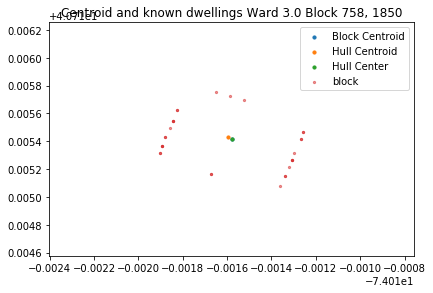

Total known dwellings in block: 30


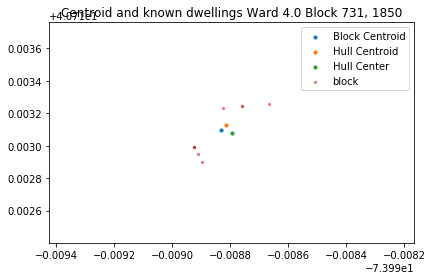

Total known dwellings in block: 9


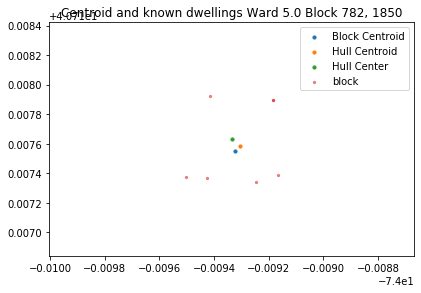

Total known dwellings in block: 7


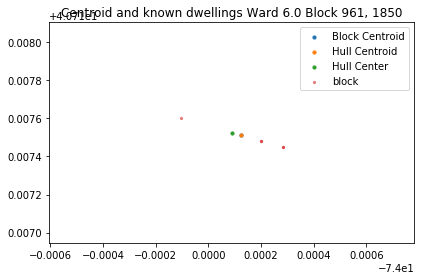

Total known dwellings in block: 5


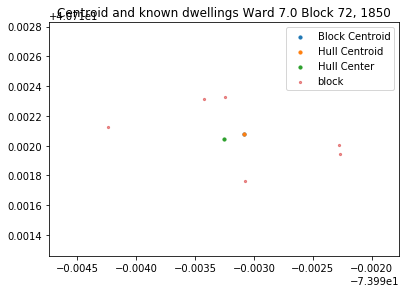

Total known dwellings in block: 6


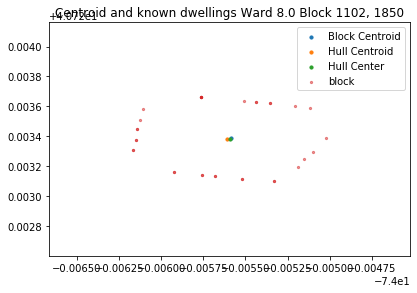

Total known dwellings in block: 34


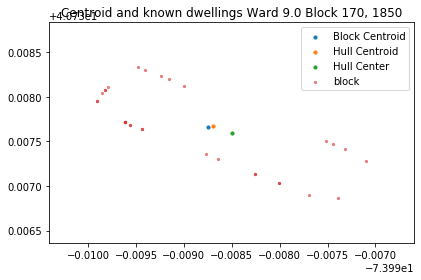

Total known dwellings in block: 31


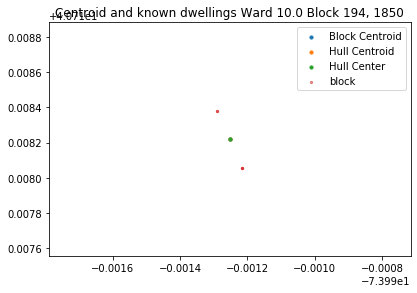

Total known dwellings in block: 5


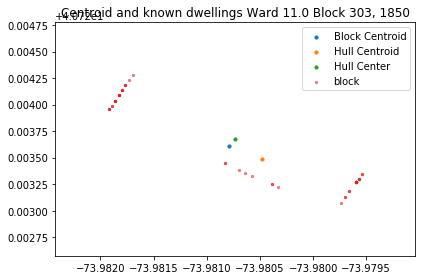

Total known dwellings in block: 54


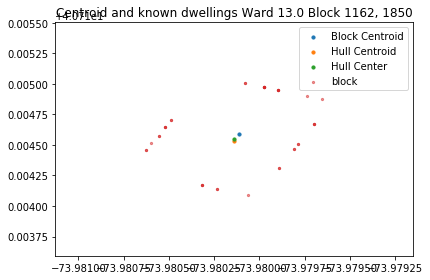

Total known dwellings in block: 39


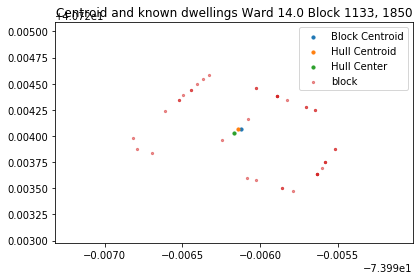

Total known dwellings in block: 42


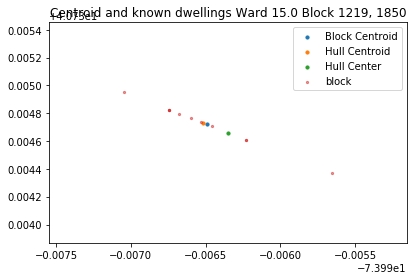

Total known dwellings in block: 11


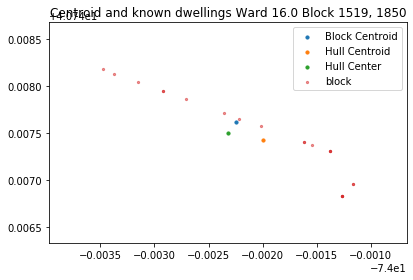

Total known dwellings in block: 21


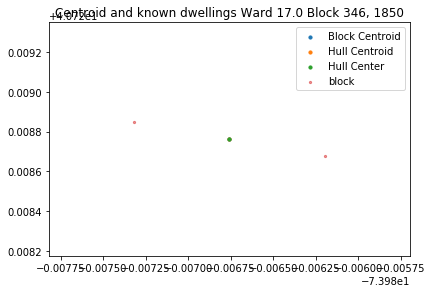

Total known dwellings in block: 2


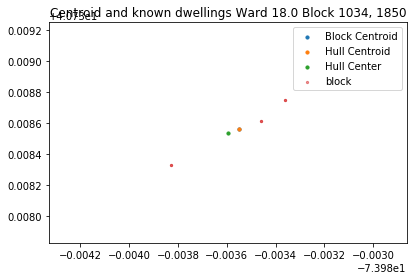

Total known dwellings in block: 6


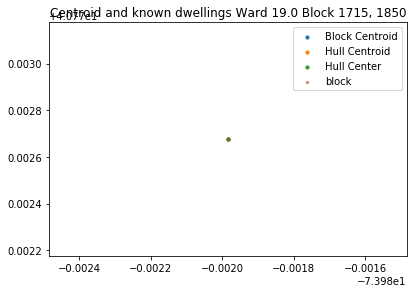

Total known dwellings in block: 1


In [68]:
np.random.seed(0)
for ward in center_list[0].keys():
    block = np.random.choice(cd_1850[cd_1850[ward_col] == ward][block_col].unique())
    centroid_vis(ward, block,  center_list, name_list, cd_1850)

## Summary

* When there are a couple of dwellings, all three measures are similar
* When known dwellings are even across a block, all three measures are similar
* When known dwellings are not even across a block, `hull center` is located at the center of a polygon
    * is more general if we assume even distributed dwellings along block borders
* `block centroid` is biased towards the area with more dwellings. 
    * Sometimes not at the center of a block. Unknown dwellings in the area that is far from the centroid can be misclassified.
* It is more common to see dwellings located on all sides of a rectangle/polygon that makes up a block. Although there are only 1 side with dwellings, we should not treat the data as if there is no dwelling on the other sides. Thus, `hull center` that takes into account an actual shape of a block seems to be better than `block centroid`.

#### Disambiguated Census Data
Look at what block centroids represent in the context of available data for that block in the 1850 disambiguation 

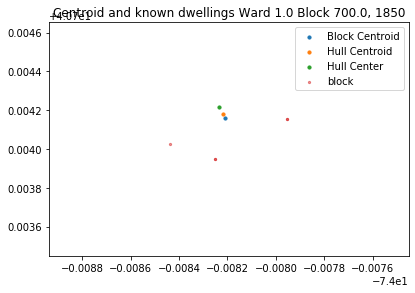

Total known dwellings in block: 5


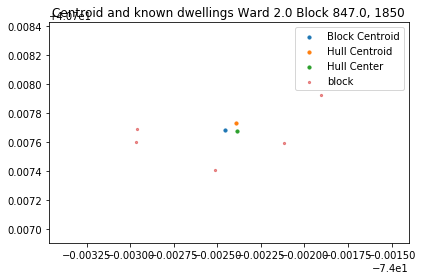

Total known dwellings in block: 5


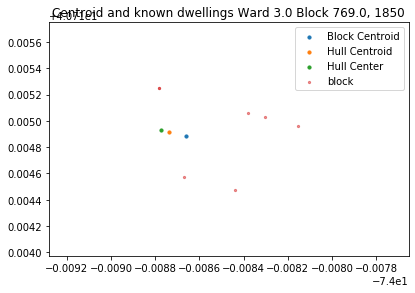

Total known dwellings in block: 7


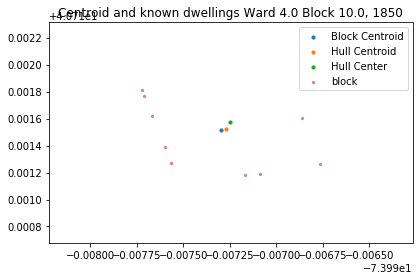

Total known dwellings in block: 9


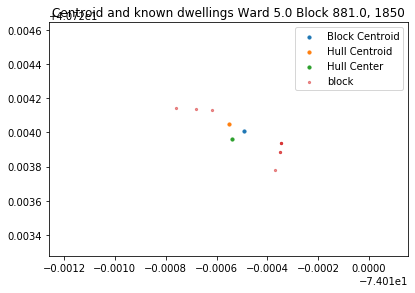

Total known dwellings in block: 9


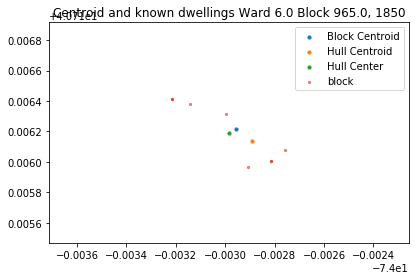

Total known dwellings in block: 8


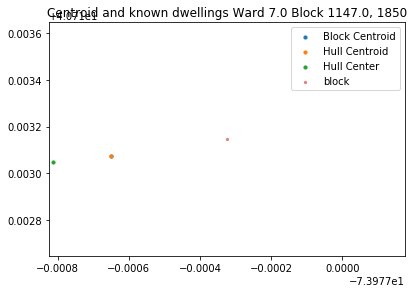

Total known dwellings in block: 1


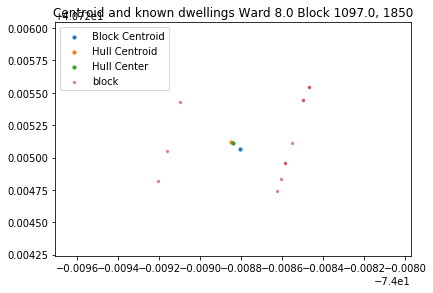

Total known dwellings in block: 12


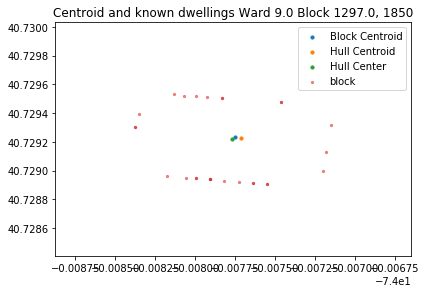

Total known dwellings in block: 27


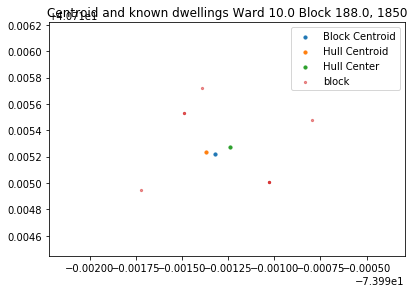

Total known dwellings in block: 8


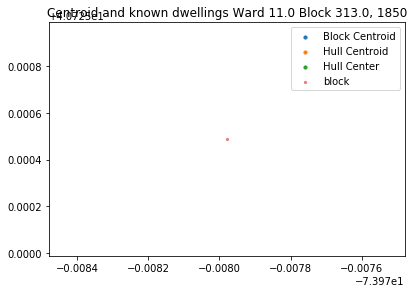

Total known dwellings in block: 1


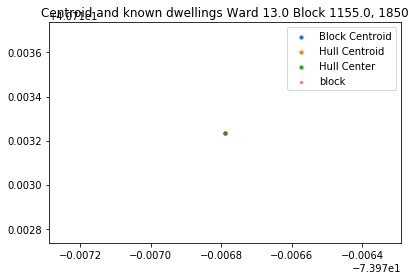

Total known dwellings in block: 1


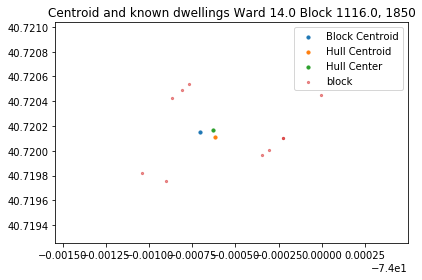

Total known dwellings in block: 10


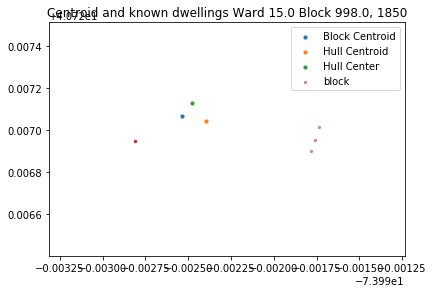

Total known dwellings in block: 7


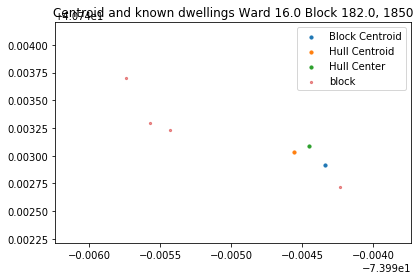

Total known dwellings in block: 4


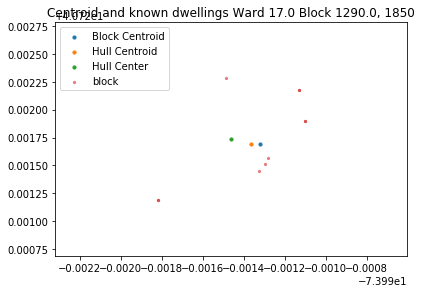

Total known dwellings in block: 10


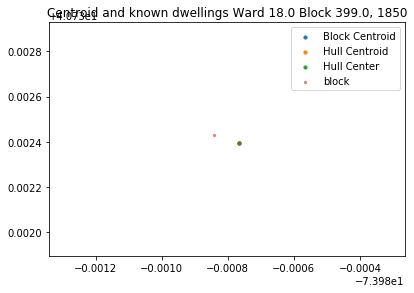

Total known dwellings in block: 2


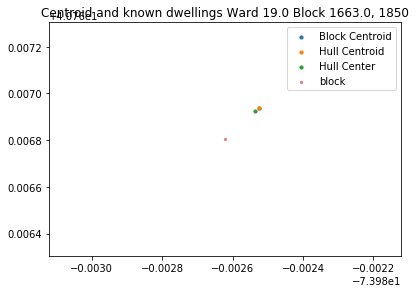

Total known dwellings in block: 1


In [69]:
dwellings_1850 = filled_1850.groupby([ward_col, dwelling_col], as_index = False).first()
for ward in center_list[0].keys():
    block = np.random.choice(dwellings_1850[dwellings_1850[ward_col] == ward][block_col].unique())
    centroid_vis(ward, block,  center_list, name_list, dwellings_1850)